In [1]:
# import requests

# url = "https://s3.amazonaws.com/talent-assets.datacamp.com/product_sales.csv"
# response = requests.get(url)

# if response.status_code == 200:
#     with open("product_sales.csv", "wb") as f:
#         f.write(response.content)
#     print("File downloaded successfully.")
# else:
#     print("Failed to download the file.")



In [2]:
import pandas as pd

sales_data = pd.read_csv("dwh/product_sales.csv")
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            13926 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [3]:
# Data validation and cleaning

# 1. Week validation: No action needed unless weeks are outside 1-6 range
weeks_valid = sales_data['week'].between(1, 6).all()

# 2. Sales Method validation: Check for unique values
sales_method_unique = sales_data['sales_method'].unique()

# 3. Customer ID: Check for uniqueness
customer_id_unique = sales_data['customer_id'].is_unique

# 4. nb_sold validation: Already appears as positive integers, but double-check
nb_sold_valid = sales_data['nb_sold'].apply(lambda x: x > 0).all()

# 5. Revenue: Check for negative values and missing data count
revenue_negative_check = (sales_data['revenue'] < 0).any()
revenue_missing_count = sales_data['revenue'].isnull().sum()

#Fill na in revenue with mean
sales_data['revenue'].fillna(round(sales_data['revenue'].mean(),2),inplace=True)
sales_data.isna().sum()

# 6. Years as Customer: Considering company founding year as 1984, validate against current year (2023)
years_as_customer_valid = sales_data['years_as_customer'].apply(lambda x: 0 <= x <= (2023 - 1984)).all()

# 7. nb_site_visits: Validate non-negative integers
nb_site_visits_valid = sales_data['nb_site_visits'].apply(lambda x: x >= 0).all()

# 8. State: Check for unique values for potential inconsistencies
state_unique = sales_data['state'].unique()

validation_results = {
    'Weeks within range 1-6': weeks_valid,
    'Sales Method unique values': sales_method_unique,
    'Customer ID unique': customer_id_unique,
    'Number sold valid': nb_sold_valid,
    'Negative revenue check': revenue_negative_check,
    'Missing revenue count': revenue_missing_count,
    'Years as customer valid': years_as_customer_valid,
    'Number of site visits valid': nb_site_visits_valid,
    'State unique values': state_unique
}

validation_results


{'Weeks within range 1-6': True,
 'Sales Method unique values': array(['Email', 'Email + Call', 'Call', 'em + call', 'email'],
       dtype=object),
 'Customer ID unique': True,
 'Number sold valid': True,
 'Negative revenue check': False,
 'Missing revenue count': 1074,
 'Years as customer valid': False,
 'Number of site visits valid': True,
 'State unique values': array(['Arizona', 'Kansas', 'Wisconsin', 'Indiana', 'Illinois',
        'Mississippi', 'Georgia', 'Oklahoma', 'Massachusetts', 'Missouri',
        'Texas', 'New York', 'Maryland', 'California', 'Tennessee',
        'Pennsylvania', 'North Dakota', 'Florida', 'Michigan',
        'North Carolina', 'Hawaii', 'Colorado', 'Louisiana', 'Virginia',
        'New Mexico', 'Arkansas', 'Alaska', 'Oregon', 'New Hampshire',
        'Ohio', 'New Jersey', 'Connecticut', 'Iowa', 'Montana',
        'Washington', 'Kentucky', 'Alabama', 'Nebraska', 'South Carolina',
        'Minnesota', 'South Dakota', 'Delaware', 'Maine', 'Utah',
        'Wes

In [4]:
# Correcting the data based on validation findings

# 1. Standardize Sales Method names
sales_data['sales_method'] = sales_data['sales_method'].replace({'em + call': 'Email + Call', 'email': 'Email'})

# 2. For now, we'll note the missing revenue but not impute values; decisions on handling this will depend on the analysis context

# 3. Correct Years as Customer: any value outside the realistic range will be adjusted to the maximum plausible value
sales_data['years_as_customer'] = sales_data['years_as_customer'].apply(lambda x: min(max(0, x), 2024 - 1984))

# Recheck the years_as_customer after correction and missing values in revenue
years_as_customer_corrected_valid = sales_data['years_as_customer'].apply(lambda x: 0 <= x <= (2024 - 1984)).all()
missing_revenue_after_correction = sales_data['revenue'].isnull().sum()

correction_results = {
    'Years as customer corrected and valid': years_as_customer_corrected_valid,
    'Missing revenue after correction': missing_revenue_after_correction
}

correction_results


{'Years as customer corrected and valid': True,
 'Missing revenue after correction': 0}

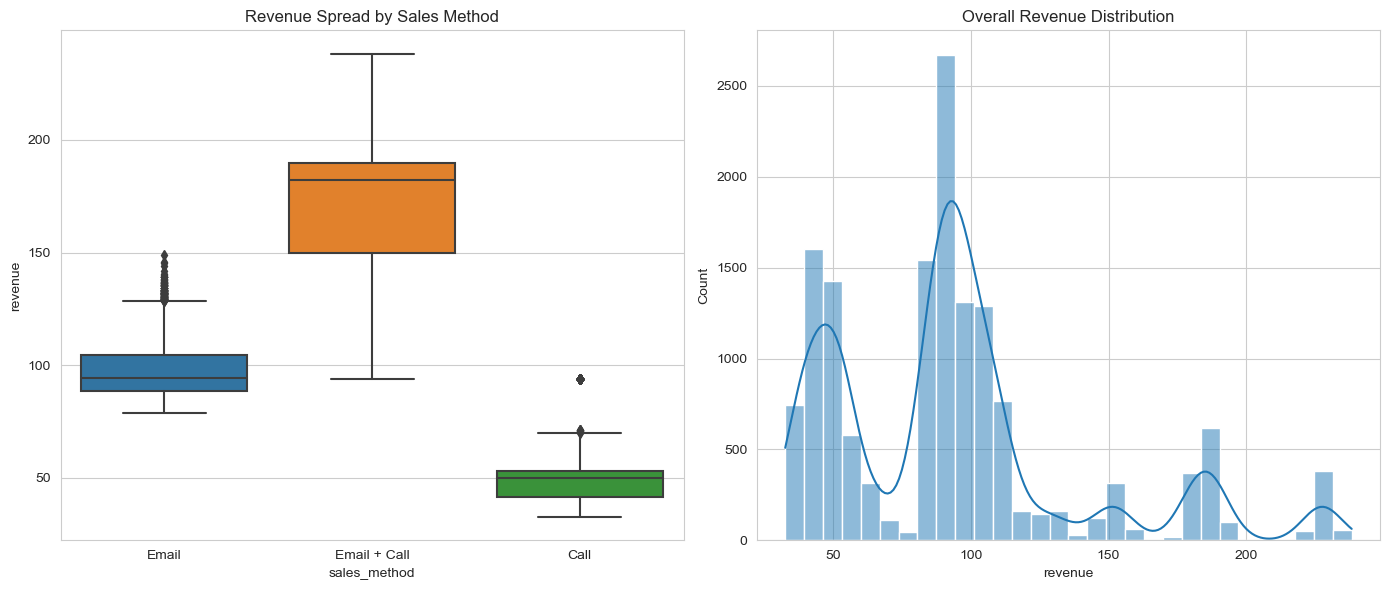

sales_method
Email           7466
Call            4962
Email + Call    2572
Name: count, dtype: int64

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Exploratory Analysis
# Distribution of customers across sales methods
sales_method_distribution = sales_data['sales_method'].value_counts()

# Revenue spread overall
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=sales_data, x='sales_method', y='revenue')
plt.title('Revenue Spread by Sales Method')

plt.subplot(1, 2, 2)
sns.histplot(data=sales_data, x='revenue', bins=30, kde=True)
plt.title('Overall Revenue Distribution')

plt.tight_layout()
plt.show()

sales_method_distribution


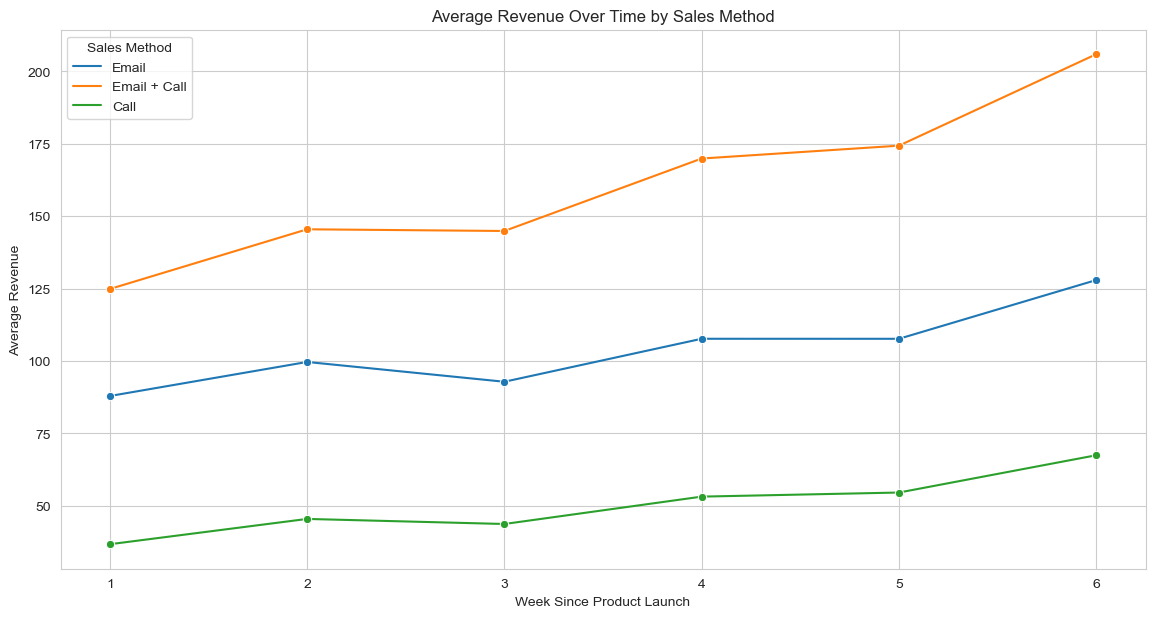

In [6]:
# Revenue Trends Over Time for Each Sales Method
plt.figure(figsize=(14, 7))
sns.lineplot(data=sales_data, x='week', y='revenue', hue='sales_method', estimator='mean', errorbar=None, marker='o')
plt.title('Average Revenue Over Time by Sales Method')
plt.xlabel('Week Since Product Launch')
plt.ylabel('Average Revenue')
plt.legend(title='Sales Method')
plt.grid(True)

plt.show()


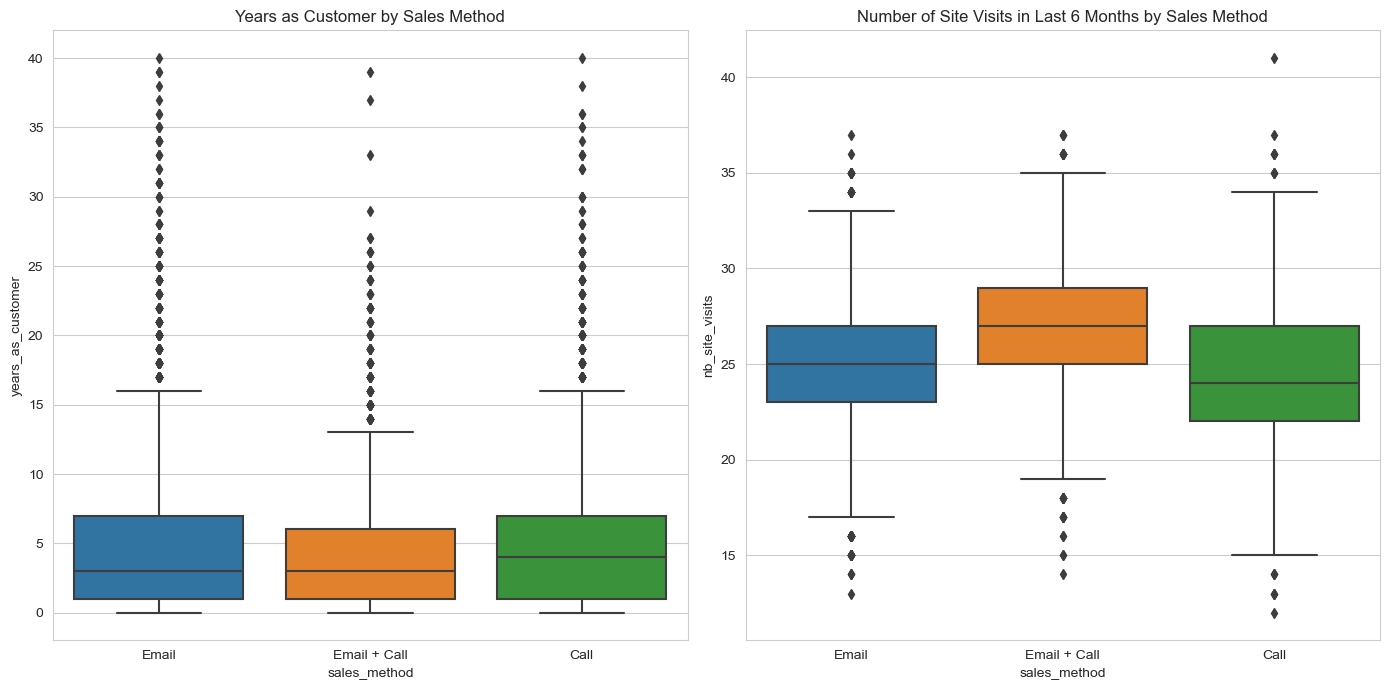

In [7]:
# Differences Between Customer Groups: Years as a Customer and Number of Site Visits
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.boxplot(data=sales_data, x='sales_method', y='years_as_customer')
plt.title('Years as Customer by Sales Method')

plt.subplot(1, 2, 2)
sns.boxplot(data=sales_data, x='sales_method', y='nb_site_visits')
plt.title('Number of Site Visits in Last 6 Months by Sales Method')

plt.tight_layout()
plt.show()


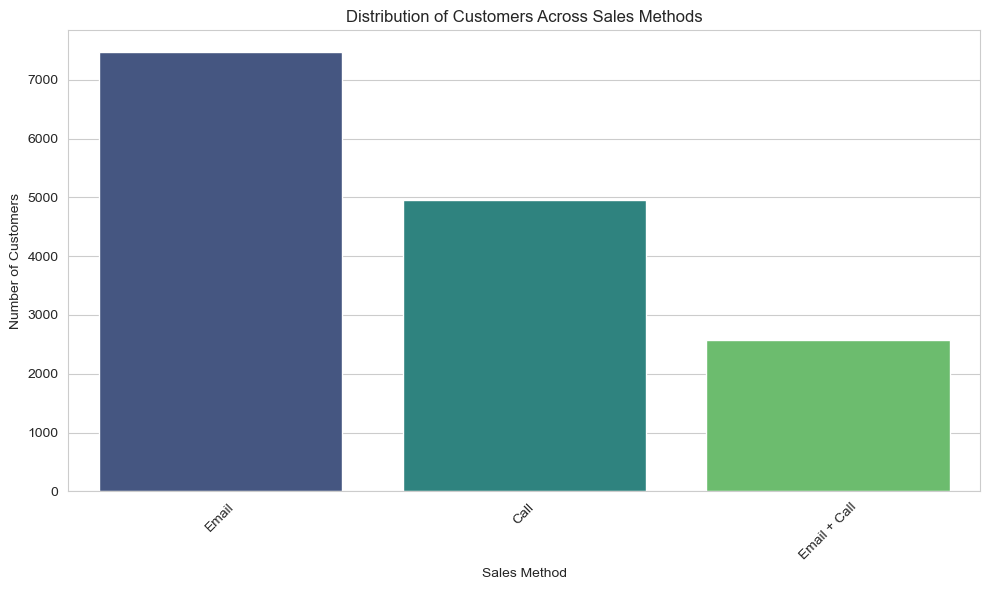

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming sales_data is your DataFrame
sales_method_counts = sales_data['sales_method'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_method_counts.index, y=sales_method_counts.values, palette="viridis")
plt.title('Distribution of Customers Across Sales Methods')
plt.xlabel('Sales Method')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


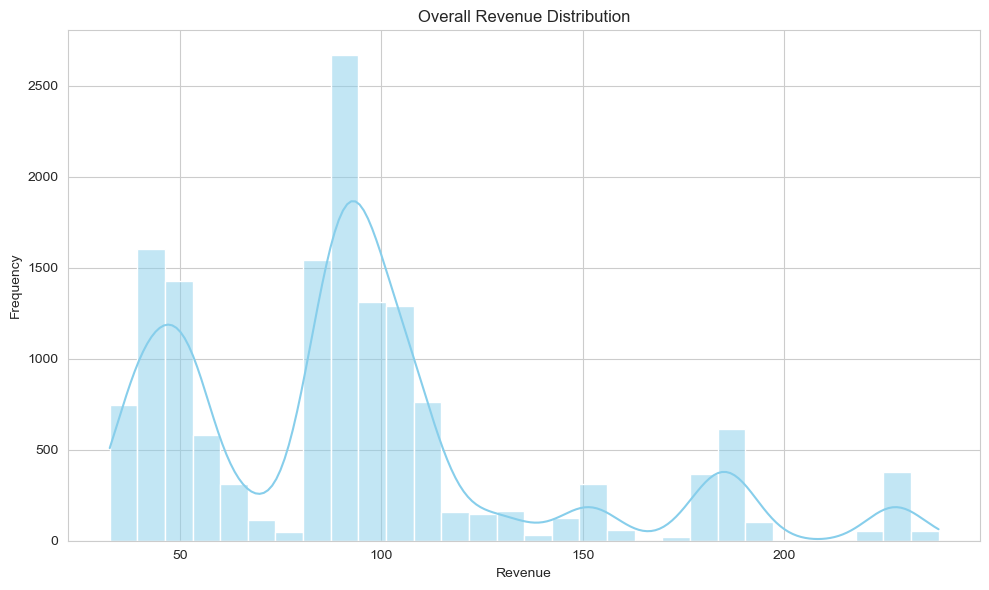

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(sales_data['revenue'].dropna(), kde=True, bins=30, color="skyblue")
plt.title('Overall Revenue Distribution')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


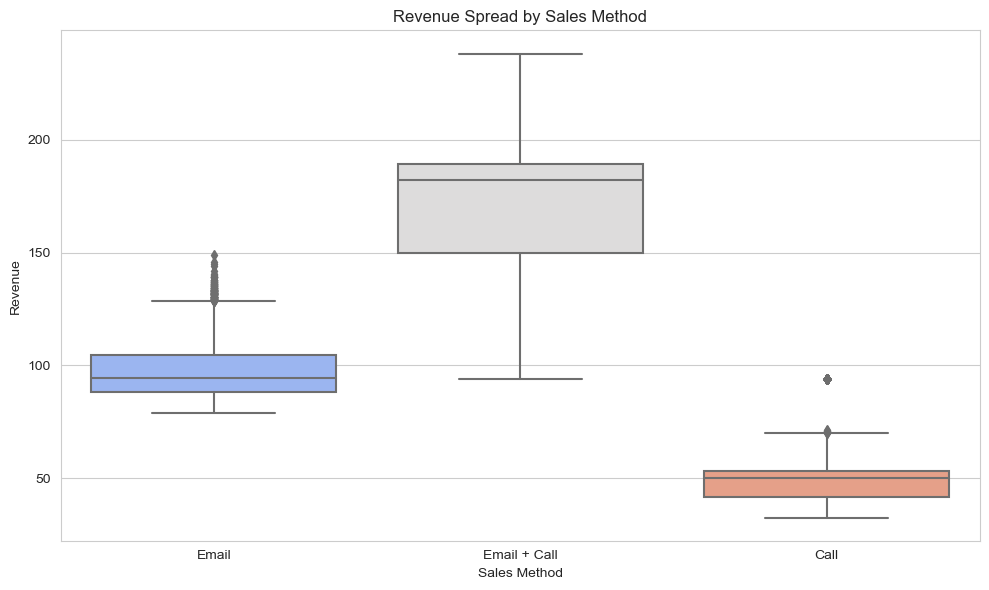

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=sales_data, x='sales_method', y='revenue', palette="coolwarm")
plt.title('Revenue Spread by Sales Method')
plt.xlabel('Sales Method')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()


/var/folders/yy/d932fdzd489ddx056zfhyrvw0000gn/T/ipykernel_9960/390826028.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=sales_data, x='week', y='revenue', hue='sales_method', estimator='mean', ci=None, marker='o', palette="tab10")


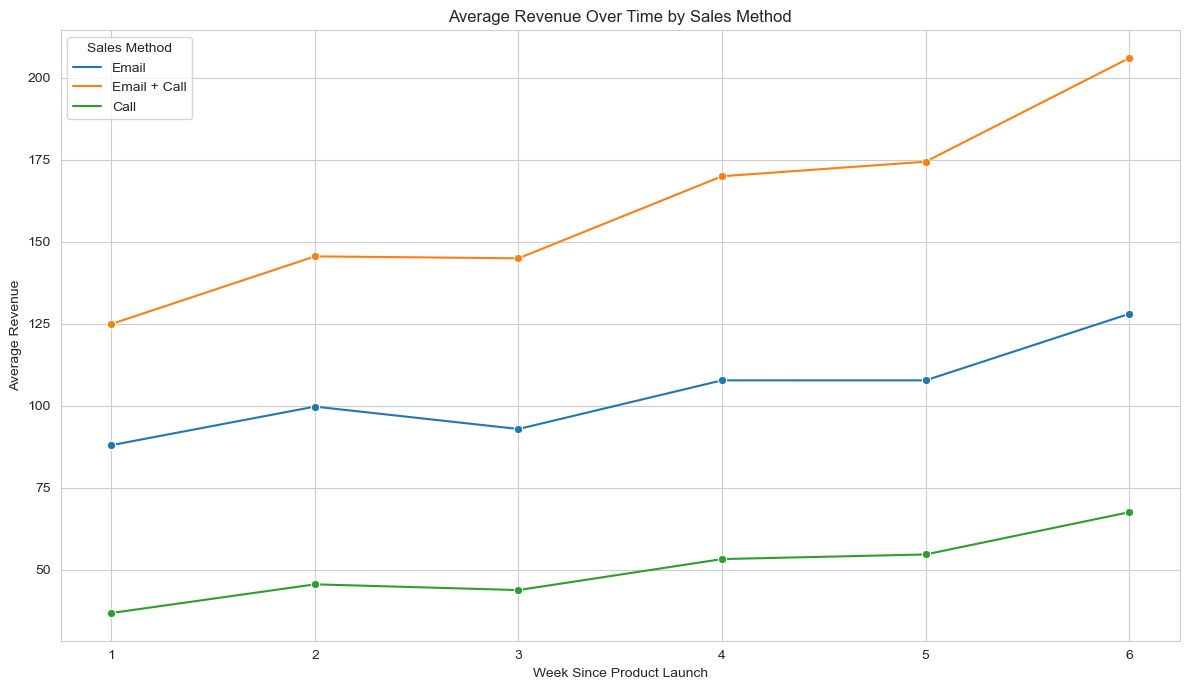

In [11]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=sales_data, x='week', y='revenue', hue='sales_method', estimator='mean', ci=None, marker='o', palette="tab10")
plt.title('Average Revenue Over Time by Sales Method')
plt.xlabel('Week Since Product Launch')
plt.ylabel('Average Revenue')
plt.legend(title='Sales Method')
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming sales_data is your DataFrame and it's already loaded

# Create bins for years as customers
bins = [0, 5, 10, 15, 20, 25, 30, 35]
labels = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35+']
sales_data['years_as_customer_bins'] = pd.cut(sales_data['years_as_customer'], bins=bins, labels=labels, right=False)

# Group data by sales method and customer years bin
plot_data_nb_sold = sales_data.groupby(['sales_method', 'years_as_customer_bins'])['nb_sold'].sum().reset_index()
plot_data_revenue = sales_data.groupby(['sales_method', 'years_as_customer_bins'])['revenue'].sum().reset_index()


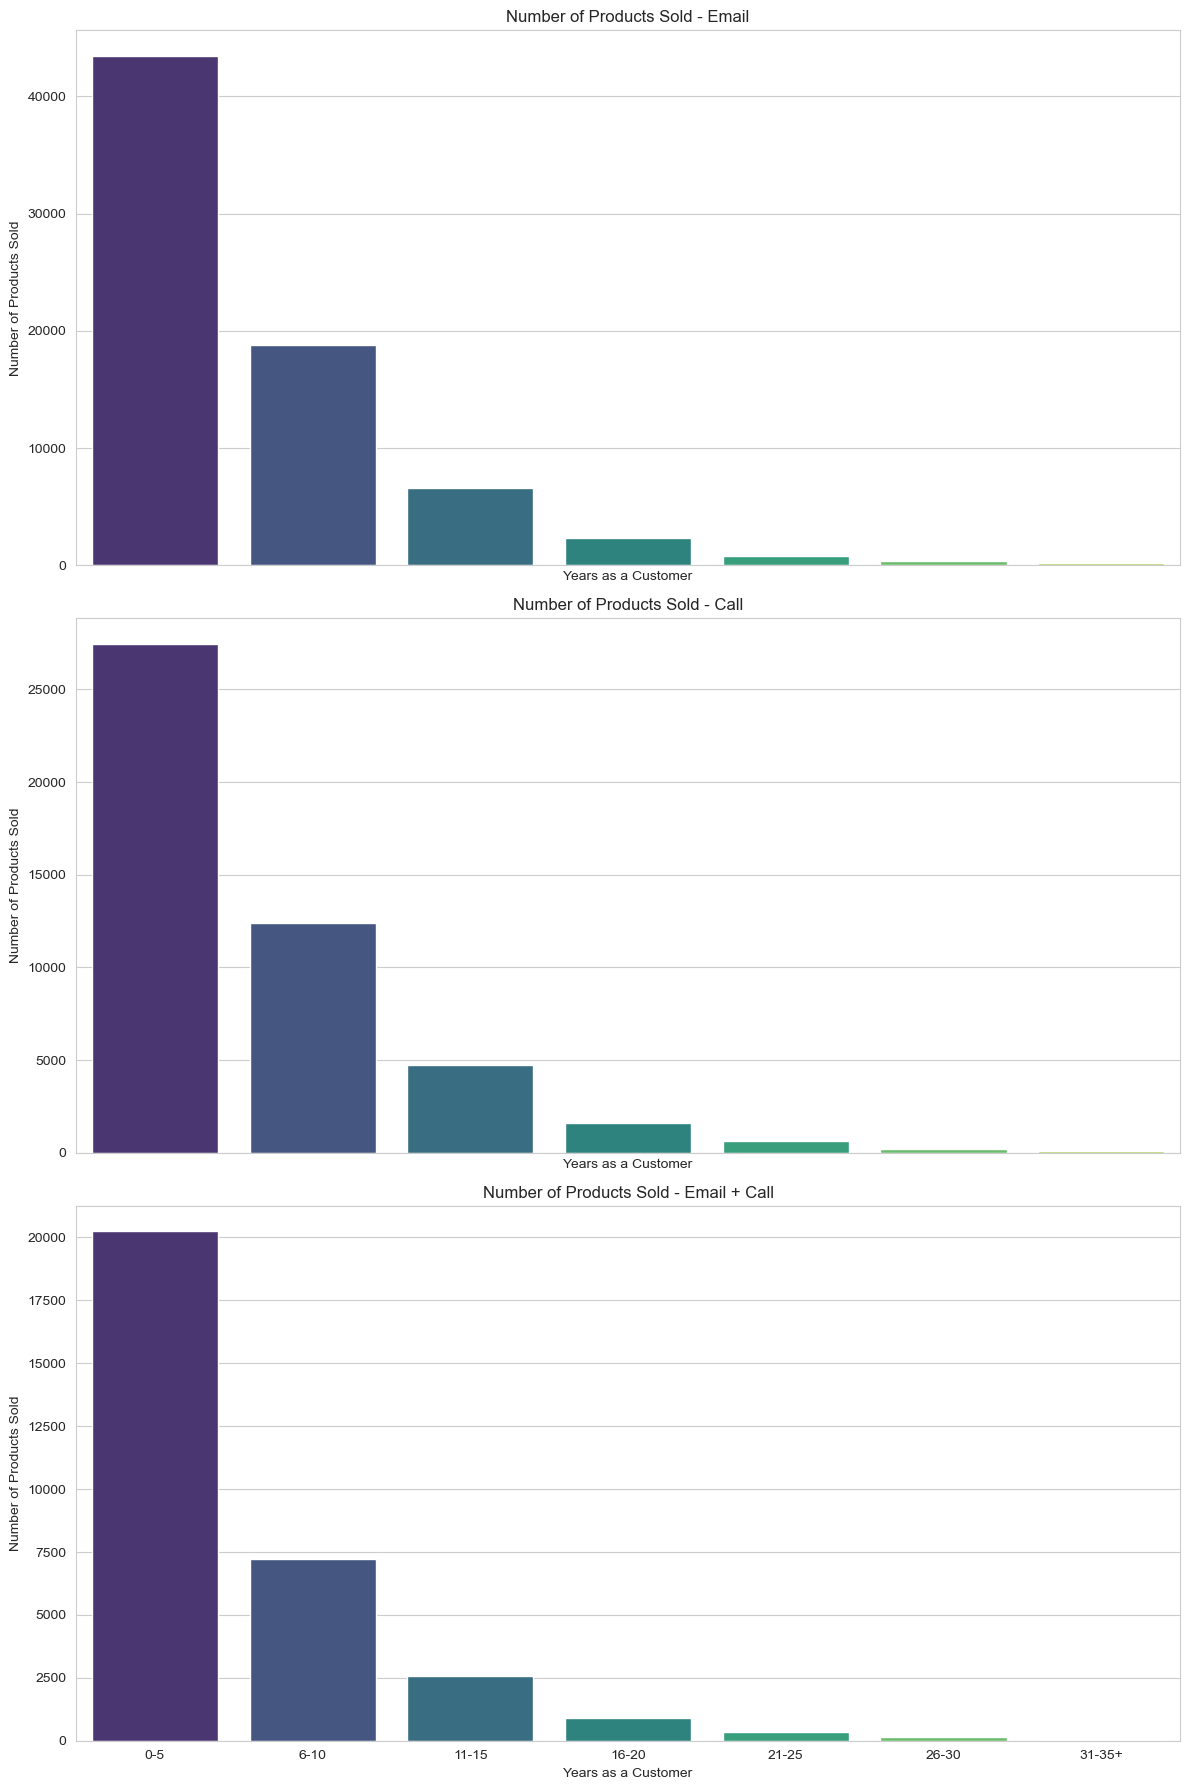

In [13]:
# Set up the matplotlib figure
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True, sharey=False)

# Plot for each sales method
for i, method in enumerate(['Email', 'Call', 'Email + Call']):
    ax = axes[i]
    subset = plot_data_nb_sold[plot_data_nb_sold['sales_method'] == method]
    sns.barplot(data=subset, x='years_as_customer_bins', y='nb_sold', ax=ax, palette='viridis')
    ax.set_title(f'Number of Products Sold - {method}')
    ax.set_xlabel('Years as a Customer')
    ax.set_ylabel('Number of Products Sold')
plt.tight_layout()
plt.show()


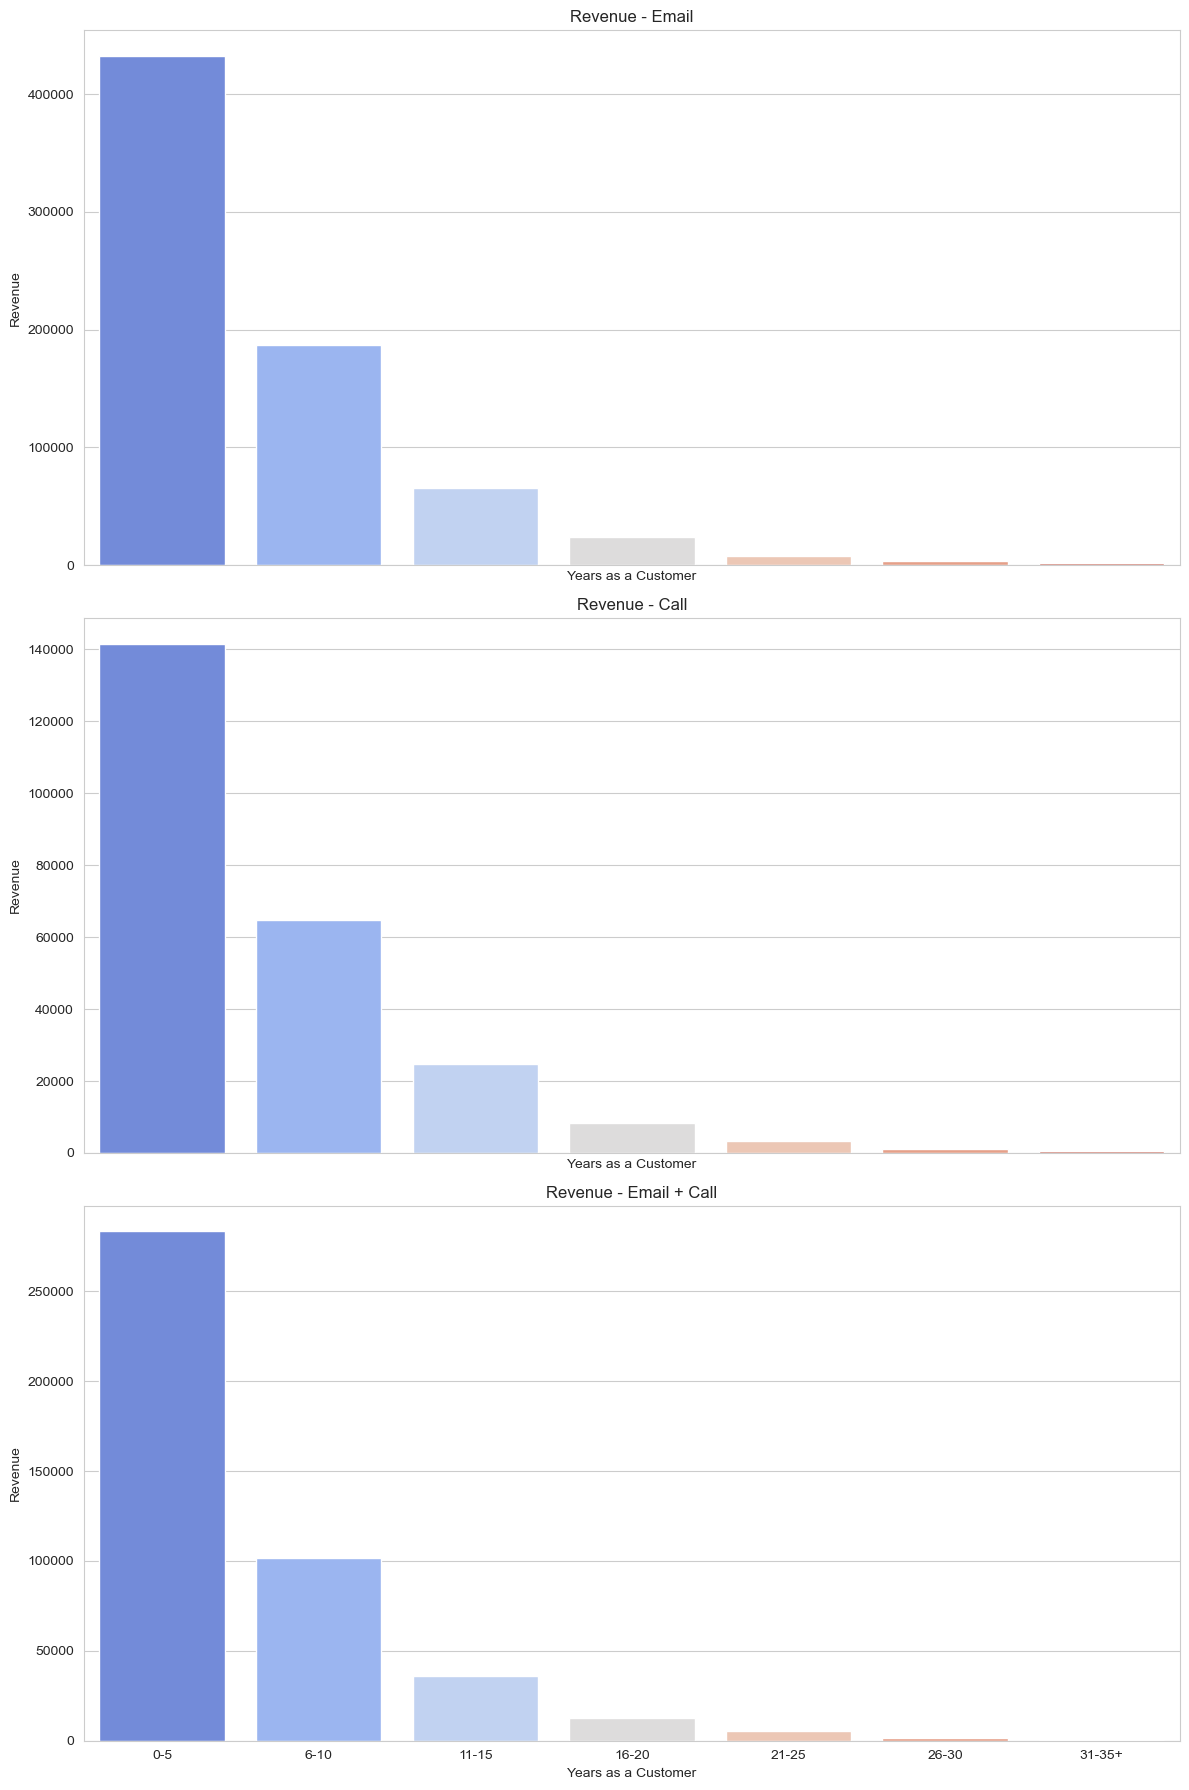

In [14]:
# Set up the matplotlib figure
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True, sharey=False)

# Plot for each sales method
for i, method in enumerate(['Email', 'Call', 'Email + Call']):
    ax = axes[i]
    subset = plot_data_revenue[plot_data_revenue['sales_method'] == method]
    sns.barplot(data=subset, x='years_as_customer_bins', y='revenue', ax=ax, palette='coolwarm')
    ax.set_title(f'Revenue - {method}')
    ax.set_xlabel('Years as a Customer')
    ax.set_ylabel('Revenue')
plt.tight_layout()
plt.show()



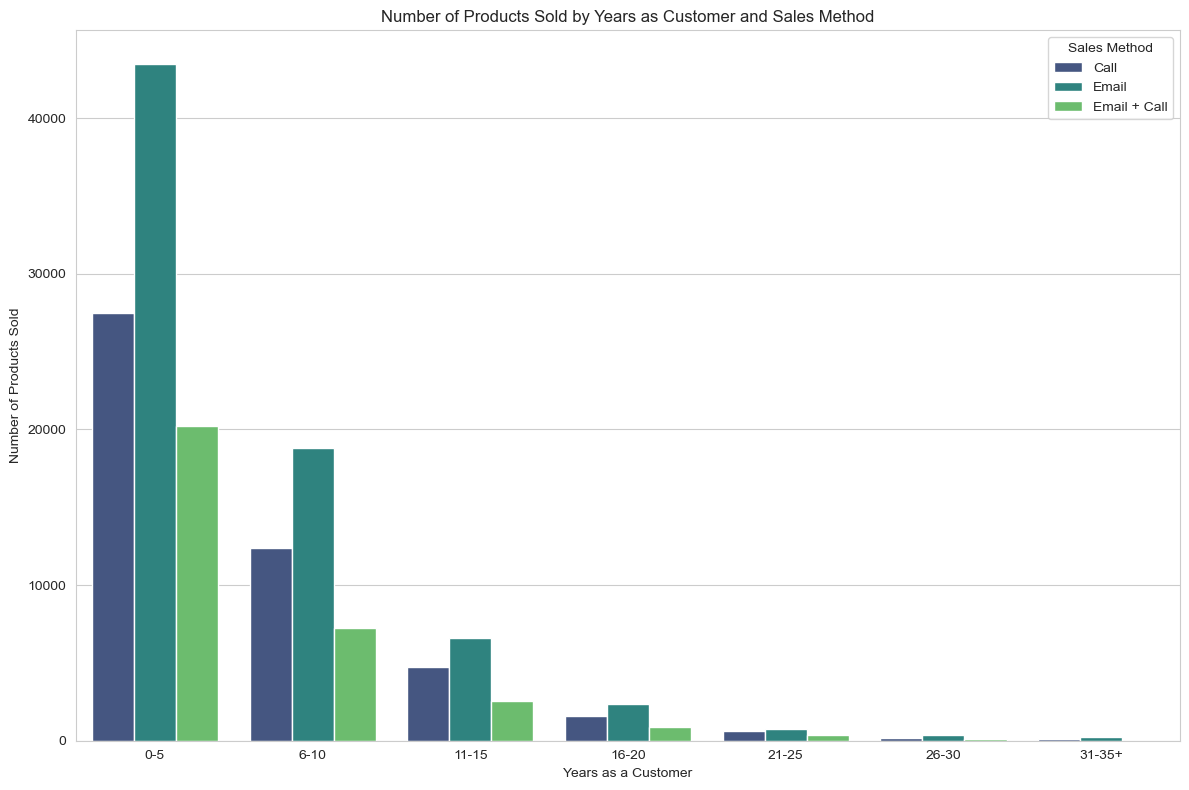

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming sales_data is your DataFrame and it's already prepared with 'years_as_customer_bins'

# Prepare data for plotting
plot_data_nb_sold = sales_data.groupby(['sales_method', 'years_as_customer_bins'])['nb_sold'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(data=plot_data_nb_sold, x='years_as_customer_bins', y='nb_sold', hue='sales_method', palette='viridis')
plt.title('Number of Products Sold by Years as Customer and Sales Method')
plt.xlabel('Years as a Customer')
plt.ylabel('Number of Products Sold')
plt.legend(title='Sales Method')
plt.tight_layout()
plt.show()


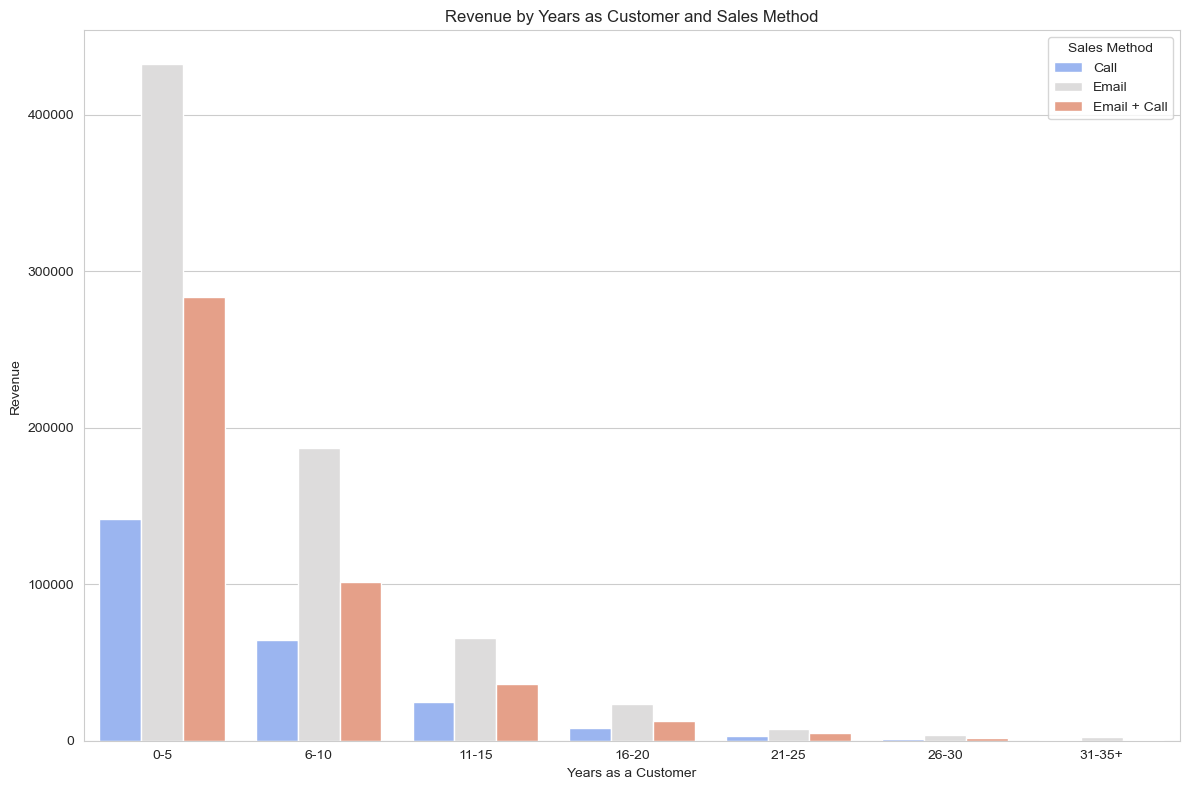

In [16]:
# Prepare data for plotting
plot_data_revenue = sales_data.groupby(['sales_method', 'years_as_customer_bins'])['revenue'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(data=plot_data_revenue, x='years_as_customer_bins', y='revenue', hue='sales_method', palette='coolwarm')
plt.title('Revenue by Years as Customer and Sales Method')
plt.xlabel('Years as a Customer')
plt.ylabel('Revenue')
plt.legend(title='Sales Method')
plt.tight_layout()
plt.show()


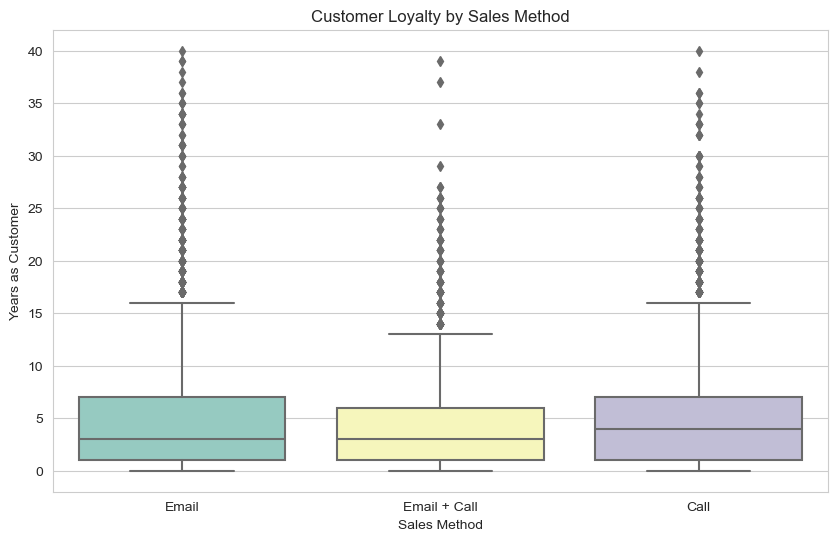

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming sales_data is your DataFrame

# Customer Loyalty Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(data=sales_data, x='sales_method', y='years_as_customer', palette="Set3")
plt.title('Customer Loyalty by Sales Method')
plt.xlabel('Sales Method')
plt.ylabel('Years as Customer')
plt.show()



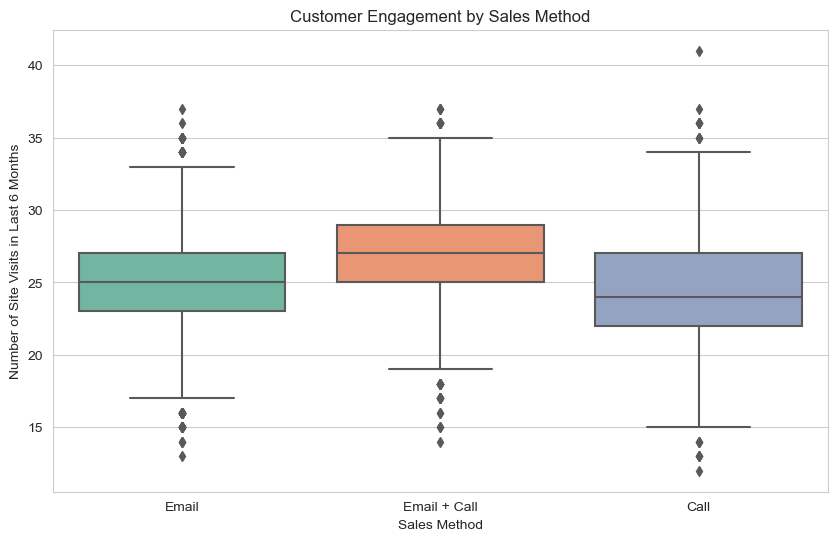

In [18]:
# Customer Engagement Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(data=sales_data, x='sales_method', y='nb_site_visits', palette="Set2")
plt.title('Customer Engagement by Sales Method')
plt.xlabel('Sales Method')
plt.ylabel('Number of Site Visits in Last 6 Months')
plt.show()


In [19]:
# Calculate the total revenue for each sales method and the overall total revenue
total_revenue_by_method = sales_data.groupby('sales_method')['revenue'].sum()
overall_total_revenue = total_revenue_by_method.sum()

# Calculate the percentage of total revenue contributed by each sales method
percentage_revenue_by_method = (total_revenue_by_method / overall_total_revenue) * 100

percentage_revenue_by_method


sales_method
Call            17.357101
Email           51.341809
Email + Call    31.301091
Name: revenue, dtype: float64

In [20]:
# Calculate total revenue and number of sales (accounts) for each sales method
arpa_data = sales_data.groupby('sales_method').agg({'revenue':'sum', 'customer_id':'nunique'}).reset_index()
arpa_data['ARPA'] = arpa_data['revenue'] / arpa_data['customer_id']

# Display ARPA for each sales method
arpa_data[['sales_method', 'ARPA']]


,sales_method,ARPA
0,Call,49.287549
1,Email,96.894689
2,Email + Call,171.476773


In [21]:
# Assuming 'sales_data' is your DataFrame and it includes 'years_as_customer' and 'revenue' columns.
average_revenue_by_loyalty = sales_data.groupby('years_as_customer')['revenue'].mean().reset_index()

# Sorting the results by years as a customer for clarity
average_revenue_by_loyalty.sort_values('years_as_customer', inplace=True)


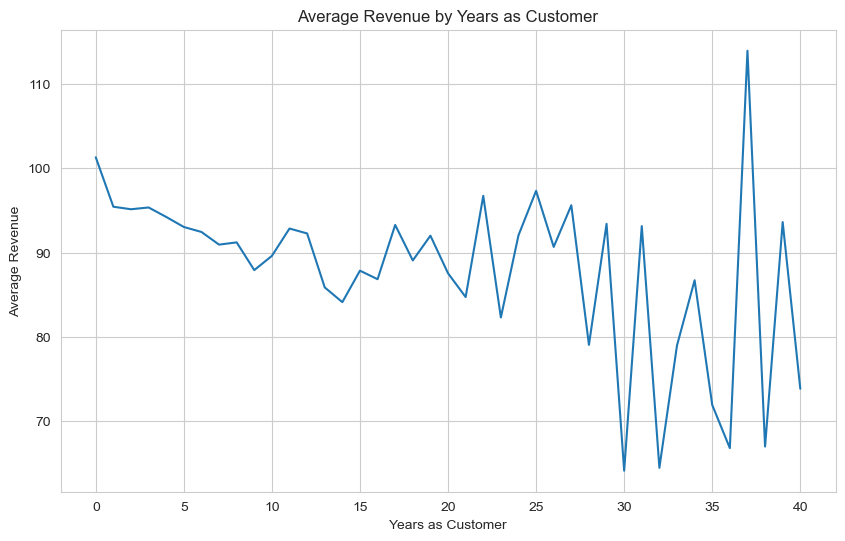

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=average_revenue_by_loyalty, x='years_as_customer', y='revenue')
plt.title('Average Revenue by Years as Customer')
plt.xlabel('Years as Customer')
plt.ylabel('Average Revenue')
plt.show()
